In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [13]:
FIN_PATH = "/home/peter/Documents/uni/FIN-Dataset"
scene = "conferenceRoom"

In [26]:
def gather_dfs(scene: str):
    root = os.path.join(FIN_PATH, scene)
    data = dict()
    for subdir in os.listdir(root):
        if not os.path.isdir(os.path.join(root, subdir)) or subdir == "GT":
            continue
        metrics_path = os.path.join(FIN_PATH, scene, subdir, "metrics", f"{subdir}-{scene}.csv")
        # sim_path = os.path.join(FIN_PATH, scene, subdir, "metrics", f"{subdir}-{scene}-sim.csv")
        # print(sim_path)
        metrics = pd.read_csv(metrics_path)
        # sim = pd.read_csv(sim_path)
        # metrics["Symmetric Similarity"] = sim["Symmetric Similarity"]
        data[subdir] = metrics
    return data

In [51]:
data = gather_dfs(scene)

/home/peter/Documents/uni/FIN-Dataset/conferenceRoom/draco/metrics/draco-conferenceRoom-sim.csv
/home/peter/Documents/uni/FIN-Dataset/conferenceRoom/tmc3/metrics/tmc3-conferenceRoom-sim.csv
/home/peter/Documents/uni/FIN-Dataset/conferenceRoom/pccomp/metrics/pccomp-conferenceRoom-sim.csv


In [53]:
files =  [file.split("-")[0][1:] for file in os.listdir(os.path.join(FIN_PATH, scene)) if os.path.isfile(os.path.join(FIN_PATH, scene, file)) and file.endswith(".ply")]
num_clouds = max(map(int, files))+1
x = np.arange(num_clouds)
len(x)

131

131
131
131


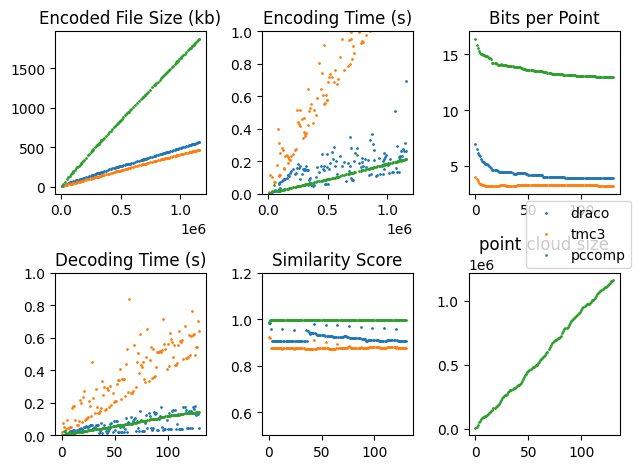

In [54]:
fig, axs = plt.subplots(2,3)
ls = []
algorithms = []
for algorithm, df in data.items():
    algorithms.append(algorithm)
    bpps = df["bpp"]
    enc_size = df["enc_file_size_bits"]/8000
    print(len(enc_size))
    time_enc = df["time_enc_ns"]/10**9
    time_dec = df["time_dec_ns"]/10**9
    points = df["num_points"]
    similarity = df["Symmetric Similarity"]
    l = axs[0, 0].scatter(points, enc_size, s=1)
    ls.append(l)
    axs[0, 0].set_title("Encoded File Size (kb)")
    axs[0, 1].scatter(points, time_enc, s=1)
    axs[0, 1].set_title("Encoding Time (s)")
    axs[1, 0].scatter(x, time_dec, s=1)
    axs[1, 0].set_title("Decoding Time (s)")
    axs[1, 1].scatter(x, similarity, s=1)
    axs[1, 1].set_title("Similarity Score")
    axs[0, 2].scatter(x, bpps, s=1)
    axs[0, 2].set_title("Bits per Point")
    axs[1, 1].set_ylim([0.5, 1.2])
    axs[0, 1].set_ylim([0, 1])
    axs[1, 0].set_ylim([0, 1])
axs[1, 2].scatter(x, points, s=1, color="tab:green")
axs[1, 2].set_title("point cloud size")
fig.legend(ls, algorithms, loc="center right")
fig.tight_layout()
plt.show()

131
131
131


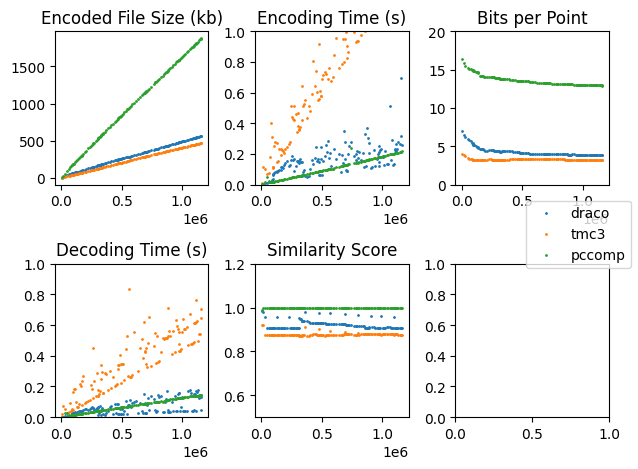

In [55]:
fig, axs = plt.subplots(2,3)
ls = []
algorithms = []
for algorithm, df in data.items():
    algorithms.append(algorithm)
    bpps = df["bpp"]
    enc_size = df["enc_file_size_bits"]/8000
    print(len(enc_size))
    time_enc = df["time_enc_ns"]/10**9
    time_dec = df["time_dec_ns"]/10**9
    points = df["num_points"]
    similarity = df["Symmetric Similarity"]
    l = axs[0, 0].scatter(points, enc_size, s=1)
    ls.append(l)
    axs[0, 0].set_title("Encoded File Size (kb)")
    axs[0, 1].scatter(points, time_enc, s=1)
    axs[0, 1].set_title("Encoding Time (s)")
    axs[1, 0].scatter(points, time_dec, s=1)
    axs[1, 0].set_title("Decoding Time (s)")
    axs[1, 1].scatter(points, similarity, s=1)
    axs[1, 1].set_title("Similarity Score")
    axs[0, 2].scatter(points, bpps, s=1)
    axs[0, 2].set_title("Bits per Point")
    axs[1, 1].set_ylim([0.5, 1.2])
    axs[0, 2].set_ylim([0, 20])
    axs[0, 1].set_ylim([0, 1])
    axs[1, 0].set_ylim([0, 1])
fig.legend(ls, algorithms, loc="center right")
fig.tight_layout()
plt.show()

In [27]:
def gather_all():
    data = dict()
    for scene in os.listdir(FIN_PATH):
        data[scene] = gather_dfs(scene)
    return data
        

x = gather_all()
x        

{'office': {'draco':      num_points  time_dec_ns       bpp  enc_file_size_bits  time_enc_ns  \
  0          8328      8901695  6.870317               57216     40885829   
  1         23427     12714272  6.202416              145304     21697246   
  2         30933     10494114  6.024634              186360     23125746   
  3         40257     16402150  5.544576              223208     31968563   
  4         47427     17748292  5.420035              257056     37781276   
  ..          ...          ...       ...                 ...          ...   
  114     1082778     41504241  3.939253             4265336    236499865   
  115     1085112     84940178  3.937710             4272856    157627331   
  116     1087941     41912606  3.936074             4282216    264408056   
  117     1091295     75429698  3.934328             4293512    133094042   
  118     1092495    151065247  3.933638             4297480    235366703   
  
                   file  
  0         T0-8328.ply  
  

In [28]:
algo_all = dict()
for scene in os.listdir(FIN_PATH):
    for algo, df in x[scene].items():
        if not algo in algo_all:
            algo_all[algo] = df
        else:
            algo_all[algo] = pd.concat([algo_all[algo],df])

In [25]:
algo_all

{'draco':      num_points  time_dec_ns       bpp  enc_file_size_bits  time_enc_ns  \
 0          8328      8901695  6.870317               57216     40885829   
 1         23427     12714272  6.202416              145304     21697246   
 2         30933     10494114  6.024634              186360     23125746   
 3         40257     16402150  5.544576              223208     31968563   
 4         47427     17748292  5.420035              257056     37781276   
 ..          ...          ...       ...                 ...          ...   
 164      892788    144703536  3.053446             2726080    247235653   
 165      896679    129159396  3.043114             2728696    150960756   
 166      904530     36834492  3.045471             2754720    254789230   
 167      908724    143336002  3.060115             2780800    111849892   
 168      911340     35387868  3.064095             2792432    233861906   
 
                 file  Symmetric Similarity  
 0        T0-8328.ply          

680
680
680


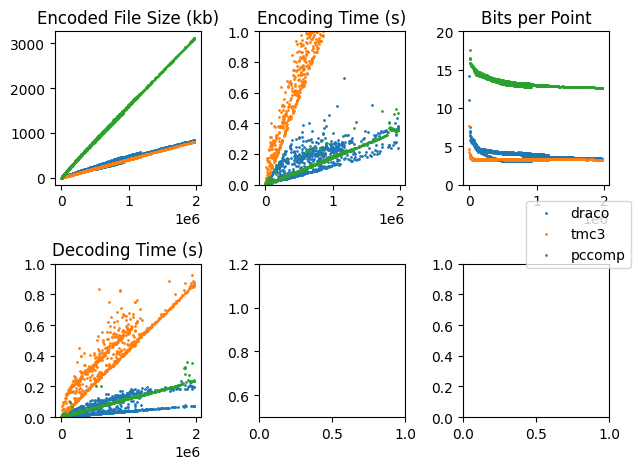

In [ ]:
fig, axs = plt.subplots(2,3)
ls = []
import matplotlib.ticker as mtick
algorithms = []
for algorithm, df in algo_all.items():
    algorithms.append(algorithm)
    bpps = df["bpp"]
    enc_size = df["enc_file_size_bits"]/8000
    print(len(enc_size))
    time_enc = df["time_enc_ns"]/10**9
    time_dec = df["time_dec_ns"]/10**9
    points = df["num_points"]
    # similarity = df["Symmetric Similarity"]
    l = axs[0, 0].scatter(points, enc_size, s=1)
    ls.append(l)
    axs[0, 0].set_title("Encoded File Size (kb)")
    axs[0, 1].scatter(points, time_enc, s=1)
    axs[0, 1].set_title("Encoding Time (s)")
    axs[1, 0].scatter(points, time_dec, s=1)
    axs[1, 0].set_title("Decoding Time (s)")
    # axs[1, 1].scatter(points, similarity, s=1)
    # axs[1, 1].set_title("Similarity Score")
    axs[0, 2].scatter(points, bpps, s=1)
    axs[0, 2].set_title("Bits per Point")
    axs[1, 1].set_ylim([0.5, 1.2])
    axs[0, 2].set_ylim([0, 20])
    axs[0, 1].set_ylim([0, 1])
    axs[1, 0].set_ylim([0, 1])
for ax in axs:
    for axx in ax:
        ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
fig.legend(ls, algorithms, loc="center right")
fig.tight_layout()
plt.show()